In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from Qatmosphere_2d import AtmosphereMaps

import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic

from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps
from qubic.lib.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import *

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)

(0.0, 0.0002)

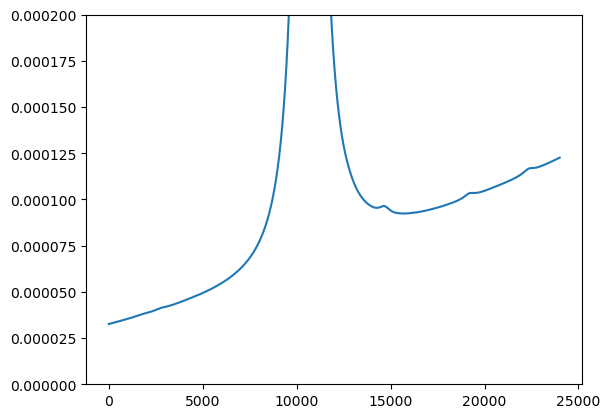

In [4]:
# Import the atm absorption spectrum
abs_spectrum = atm.absorption_spectrum()

plt.plot(abs_spectrum)
plt.ylim(0, 0.0002)

In [5]:
# Import the atm temperature maps
atm_maps = atm.get_temp_maps(atm.rho_map)
print(atm_maps.shape)

# Import the atm integrated absorption spectrum
integrated_abs_spectrum, frequencies = atm.integrated_absorption_spectrum()

(20, 786432)


Text(0, 0.5, 'Integrated absorption spectrum')

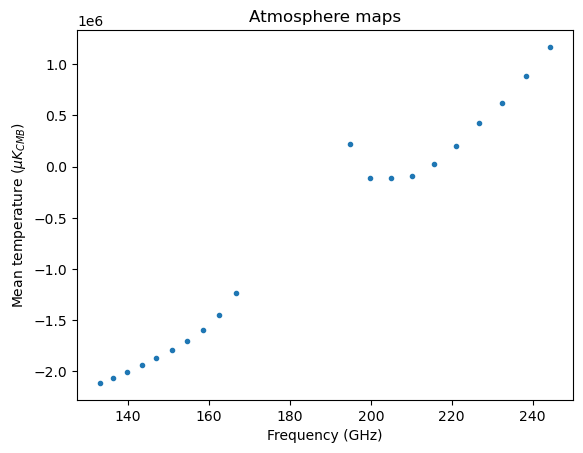

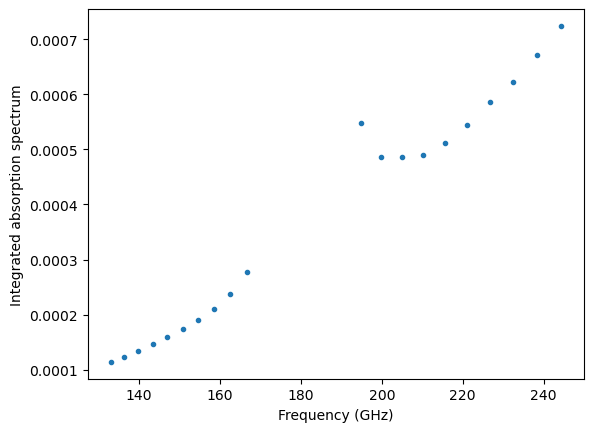

In [6]:
mean_atm_maps = []
for i in range(atm_maps.shape[0]):
    mean_atm_maps.append(np.mean(atm_maps[i, :]))
plt.figure()
plt.plot(frequencies, mean_atm_maps, '.')
plt.title('Atmosphere maps')
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.figure()
plt.plot(frequencies, integrated_abs_spectrum, '.')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Integrated absorption spectrum')

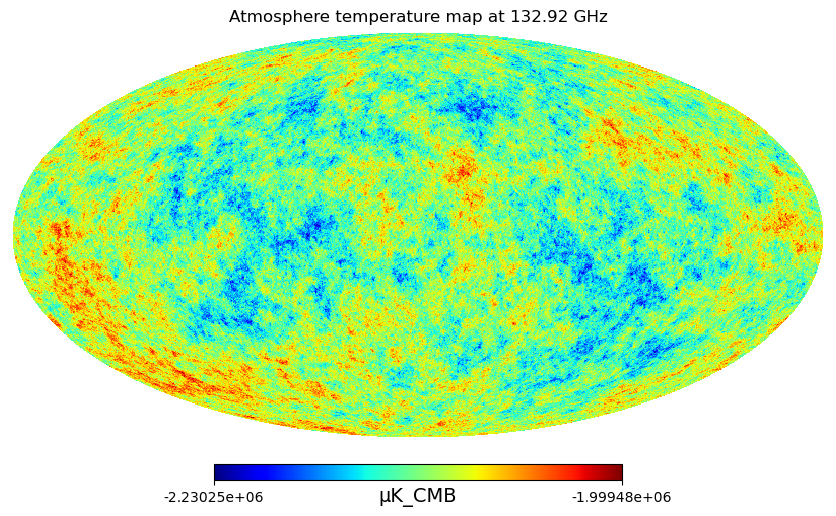

In [7]:
hp.mollview(atm_maps[0], title='Atmosphere temperature map at {:.2f} GHz'.format(frequencies[0]), cmap='jet', unit='µK_CMB')

(20, 786432, 3)


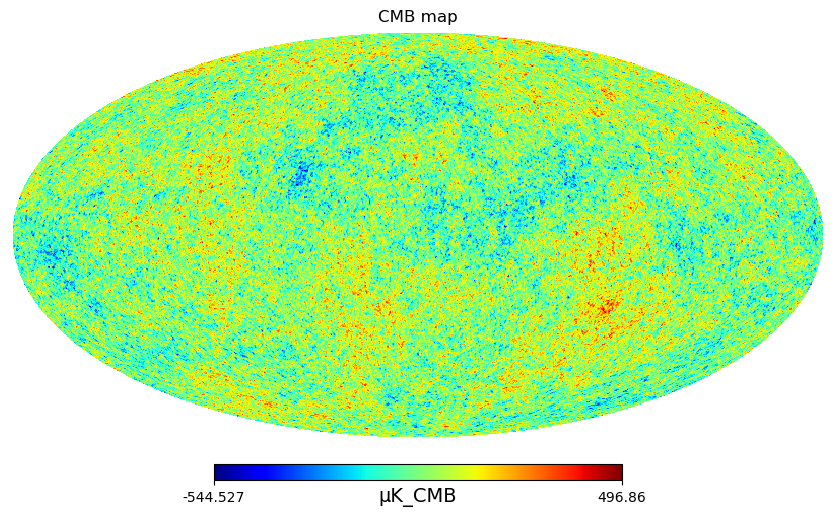

In [8]:
# Import CMB maps
cmb_maps = InputMaps({'cmb':42}, atm.frequencies, 2, params['nside']).m_nu
print(cmb_maps.shape)
hp.mollview(cmb_maps[-1, :, 0],cmap='jet', unit='µK_CMB', title='CMB map')

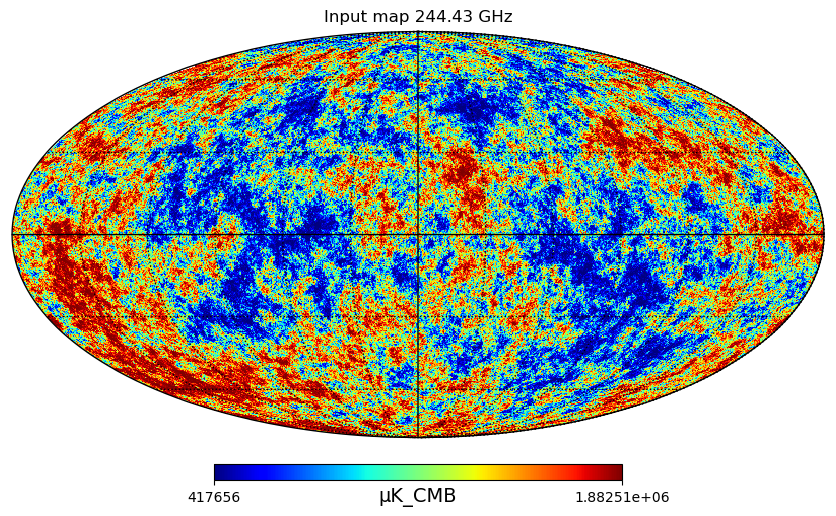

In [9]:
# Build input maps : CMB + Atmsophere (only for I map)
input_maps = cmb_maps.copy()
input_maps[:, :, 0] += atm_maps

hp.mollview(input_maps[-1, :, 0] ,cmap='jet', unit='µK_CMB', norm='hist', title='Input map {:.2f} GHz'.format(frequencies[-1]))
hp.graticule()

(2, 786432, 3)
[149.22332137 218.86087134]


(130.0, 250.0)

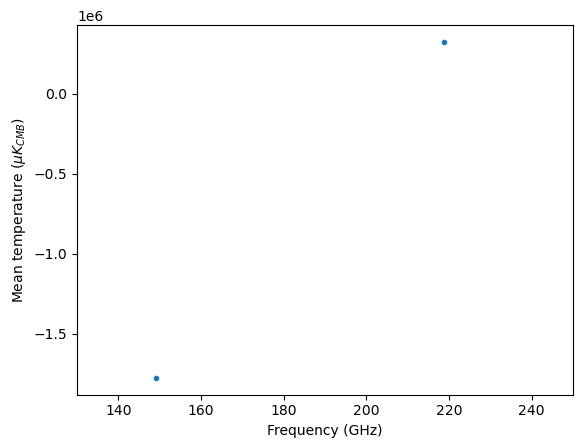

In [10]:
# Compute the Nrec maps from the Nsub maps
true_maps = np.zeros((params['nrec'], 12*params['nside']**2, 3))
true_frequencies = np.zeros(params['nrec'])
fsub = int(params['nsub_in'] / params['nrec'])
for i in range(params['nrec']):
    true_maps[i, :, :] = np.mean(input_maps[i*fsub:(i+1)*fsub, :, :], axis=0)
    true_frequencies[i] = np.mean(frequencies[i*fsub:(i+1)*fsub])
print(true_maps.shape) 
print(true_frequencies)   
plt.plot(true_frequencies, np.mean(true_maps, axis=1)[..., 0], '.')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.xlabel('Frequency (GHz)')
plt.xlim(130, 250)

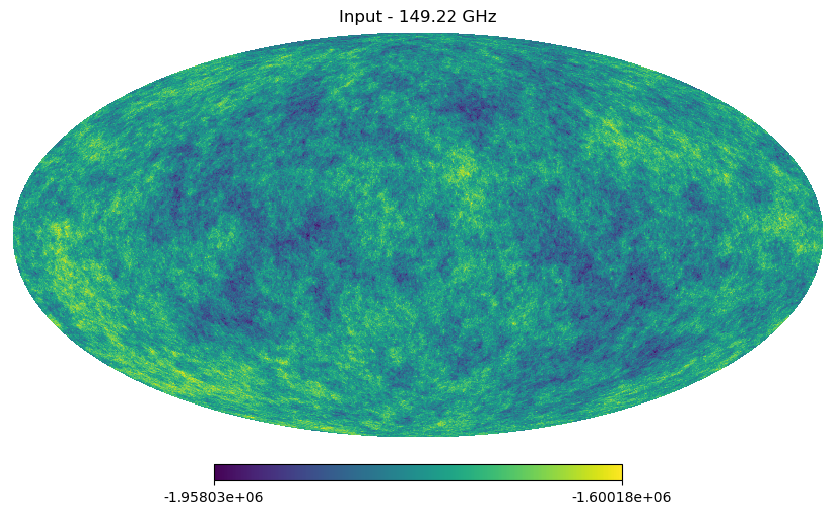

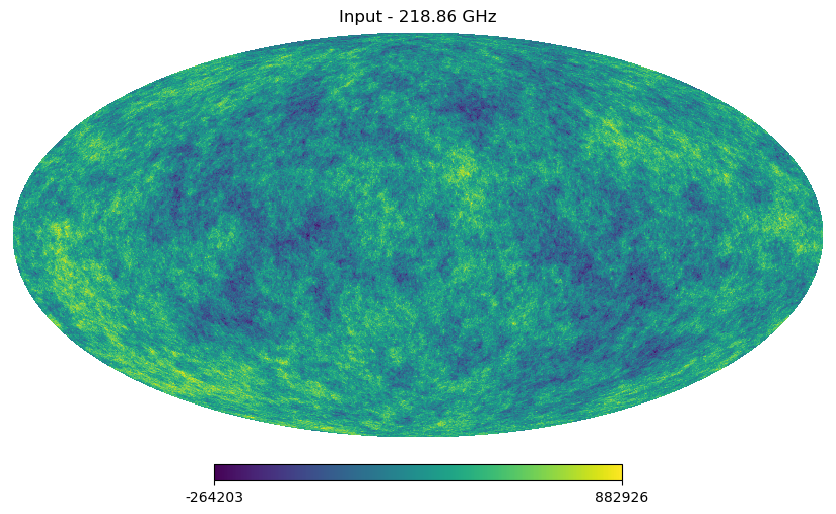

In [11]:
for inu in range(len(true_frequencies)):
    hp.mollview(true_maps[inu, :, 0],title='Input - {:.2f} GHz'.format(true_frequencies[inu]))

# Map-making

In [ ]:
#coverage = joint.qubic.subacqs[0].get_coverage()
coverage = Qacq.coverage

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

In [48]:
# Build the QUBIC operators
H_tod_qubic = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nsub_in']).get_operator()
Qacq = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nrec'])
H_rec_qubic = Qacq.get_operator().operands[1]
invN_qubic = Qacq.get_invntt_operator()
tod_qubic = H_tod_qubic(input_maps).ravel()

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMat

In [49]:
print('H_rec', H_rec_qubic.shapein, H_rec_qubic.shapeout)
print('invN', invN_qubic.shapein, invN_qubic.shapeout)
print('H_tod', H_tod_qubic.shapein, H_tod_qubic.shapeout)

H_rec (2, 786432, 3) (2, 992, 1998)
invN (1984, 1998) (1984, 1998)
H_tod (20, 786432, 3) (1984, 1998)


In [50]:
# Build "external data" operators
H_rec_ext = ReshapeOperator(true_maps.shape, true_maps.ravel().shape)
invN_ext = DiagonalOperator(np.ones(H_rec_ext.shapeout))

In [51]:
H_tod = H_tod_qubic
H_rec = H_rec_qubic
R = ReshapeOperator(invN_qubic.shapeout, invN_qubic.shape[0])
invN = R(invN_qubic(R.T))
tod = tod_qubic

ValueError: The operands have incompatible shapes: '[(786432, 3), (2, 786432, 3)]'.

In [34]:
print("H_rec", H_rec.shapein, H_rec.shapeout)
print("invN", invN.shapein, invN.shapeout)
print("TOD", tod.shape)

H_rec (2, 786432, 3) (8682624,)
invN (8682624,) (8682624,)
TOD (8682624,)


In [36]:
# Build PCG
A = H_rec.T * invN * H_rec
b = H_rec.T * invN * tod
x0 = true_maps

In [37]:
print('A', A.shapein, A.shapeout)
print('b', b.shape)

A (2, 786432, 3) (2, 786432, 3)
b (2, 786432, 3)


In [38]:
# Code to compute the preconditioner

approx_hth = np.zeros((x0.shape))
conditioner = np.zeros((x0.shape))
vec = np.ones(Qacq.H[0].shapein)

for i in range(x0.shape[0]):
    for j in range(x0.shape[0]):
        approx_hth[i] = (
            Qacq.H[i].T
            * Qacq.invn220
            * Qacq.H[j](vec)
        )
fsub_out = int(params["nsub_in"] / params["nrec"])
for irec in range(params["nrec"]):
    imin = irec * fsub_out
    imax = (irec + 1) * fsub_out
    for istk in range(3):
        conditioner[irec, seenpix, istk] = 1 / (
            np.sum(approx_hth[imin:imax, seenpix, 0], axis=0)
        )

conditioner[conditioner == np.inf] = 1
M = DiagonalOperator(conditioner)

In [39]:
print(M.shapein, M.shapeout)

(2, 786432, 3) (2, 786432, 3)


In [40]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=50,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 2.2077e+00 3.38165 [1.23134936e+05 4.79918740e-11 4.80727830e-11 1.20102620e+05
 2.86267905e-11 2.85660453e-11]
   2: 1.9957e-01 3.51787 [1.30832363e+05 4.64182361e-11 4.64924959e-11 1.04733048e+06
 4.09855465e-11 3.96107759e-11]
   3: 8.7728e-02 2.97733 [1.53551254e+05 4.03492426e-11 4.03900009e-11 1.05806887e+06
 6.48478182e-11 5.90118454e-11]
   4: 2.7716e-02 3.01971 [1.50223998e+05 3.66940064e-11 3.67108166e-11 1.06487056e+06
 6.22792046e-11 5.78611705e-11]
   5: 1.1630e-02 2.96408 [1.46483784e+05 3.44224538e-11 3.44269101e-11 1.06239259e+06
 5.56605743e-11 5.29878828e-11]
   6: 7.4850e-03 3.01465 [1.46123467e+05 3.19548812e-11 3.19490952e-11 1.05715470e+06
 5.17086792e-11 5.00489668e-11]
   7: 4.8847e-03 2.97962 [1.47366602e+05 2.97463016e-11 2.97355204e-11 1.05153110e+06
 5.08740643e-11 4.93505907e-11]
   8: 2.9900e-03 3.35198 [1.47560412e+05 2.85977341e-11 2.85892524e-11 1.04765415e+06
 5.18107008e-11 4.99542706e-11]
   9: 1.7218e-03 3.03548 [1.4714

Text(0, 0.5, 'Convergence')

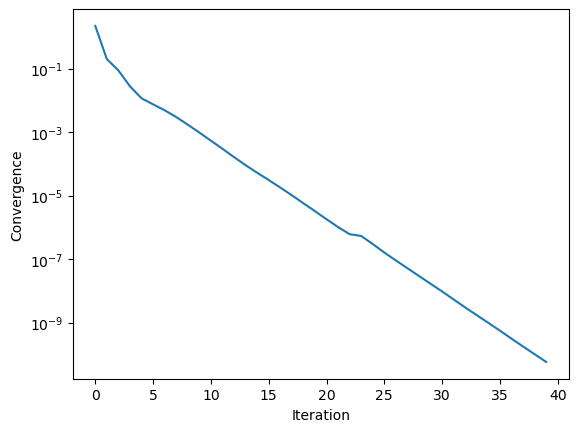

In [41]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

In [42]:
stokes = ['I', 'Q', 'U']

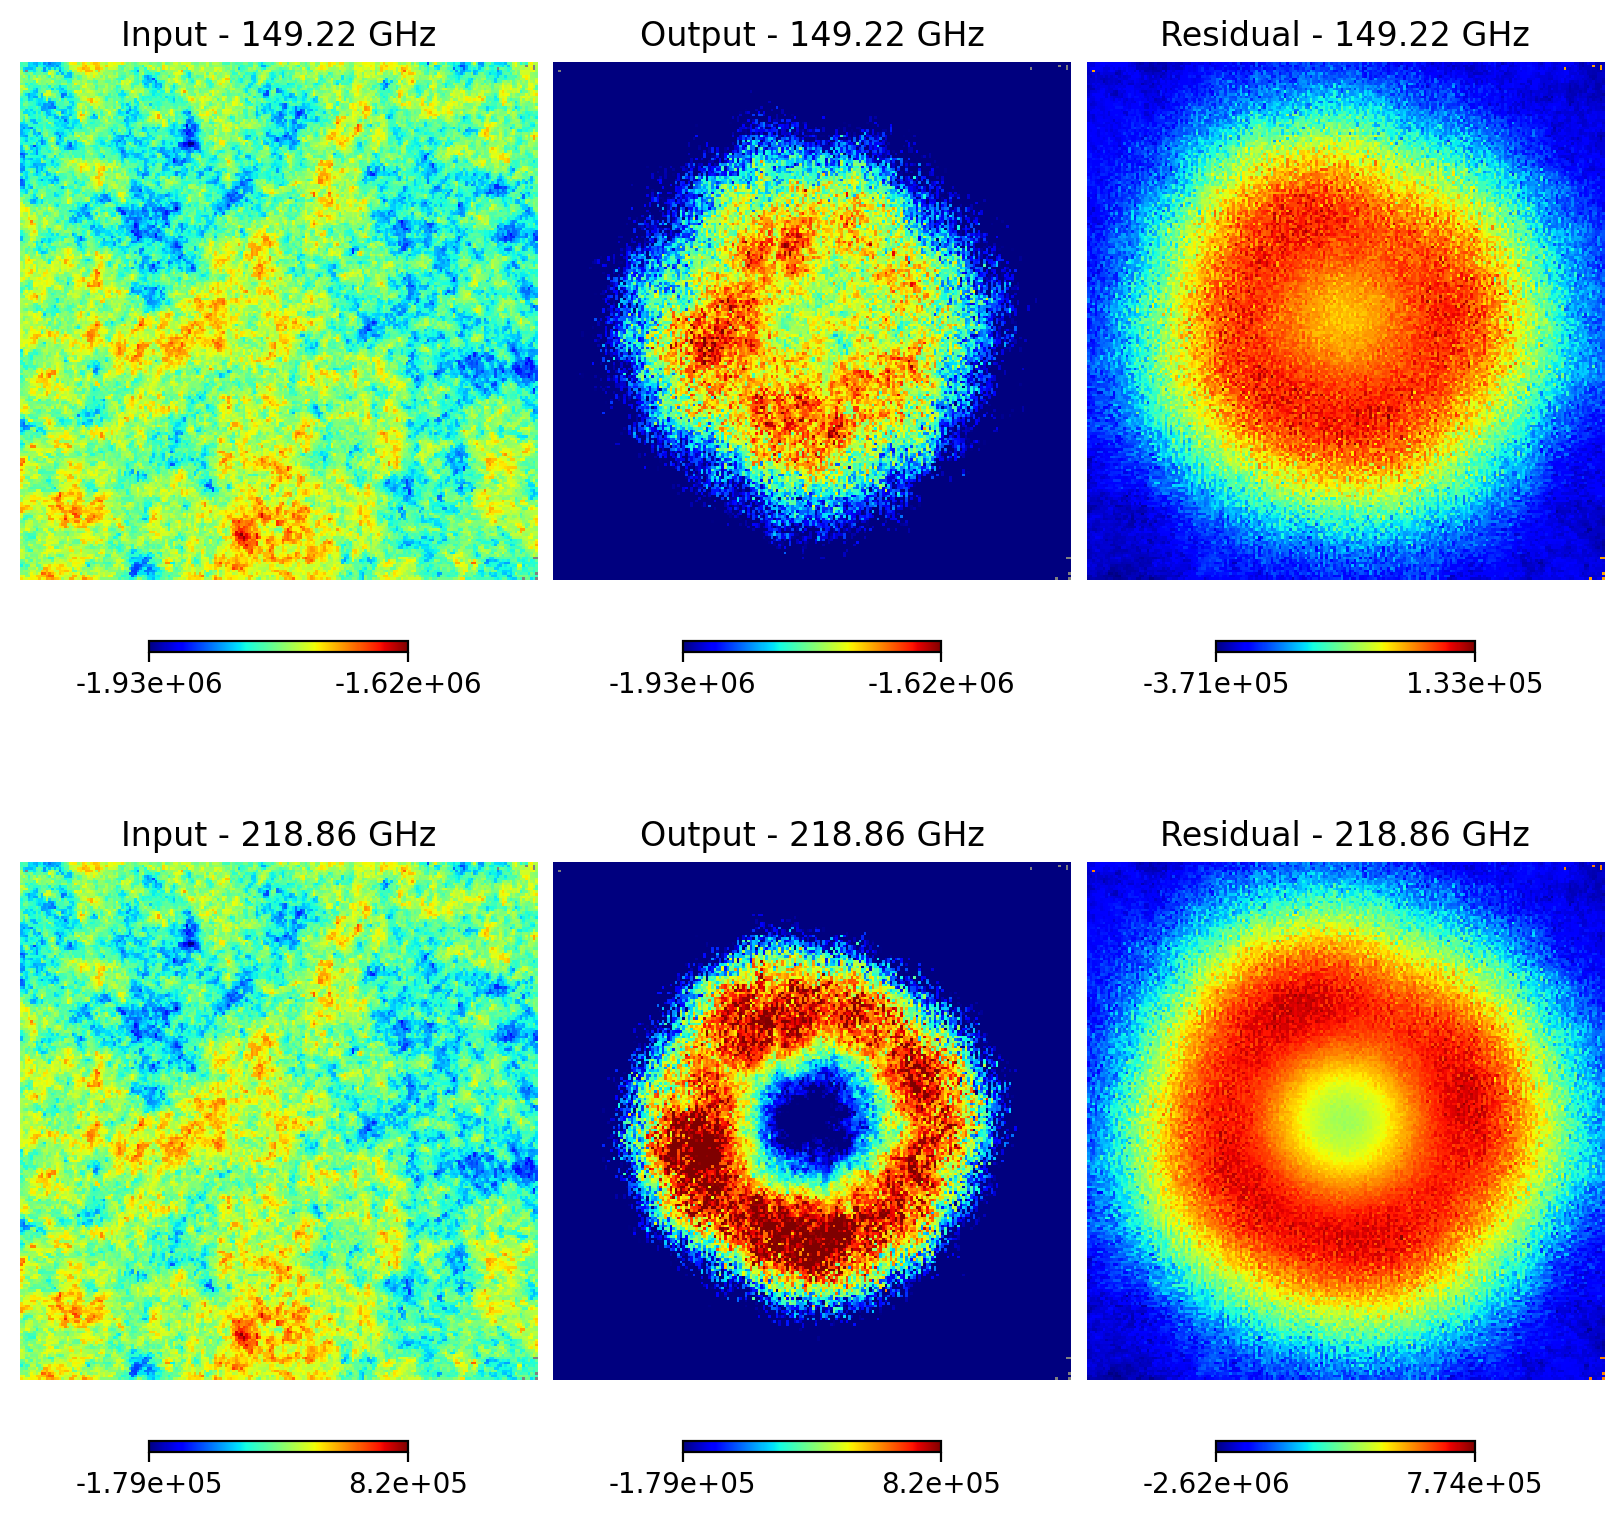

In [43]:

plt.figure(figsize=(8, 8), dpi=200)
k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3
reso = 15

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, 0], cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3

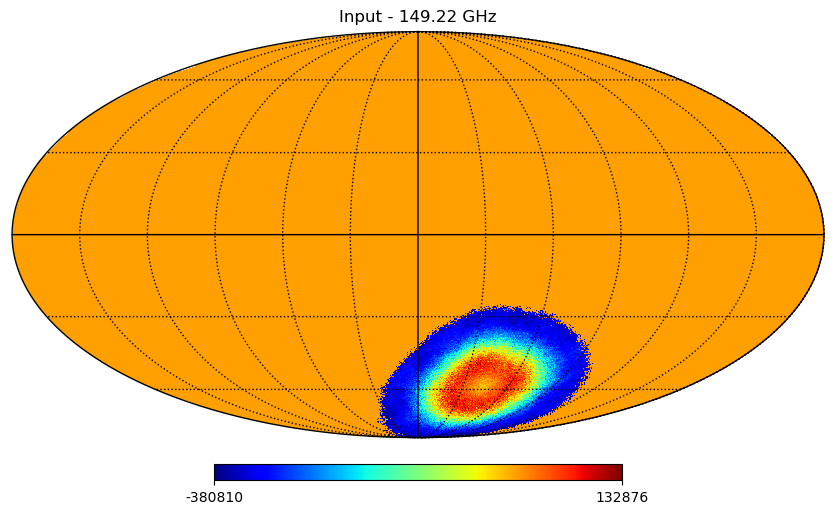

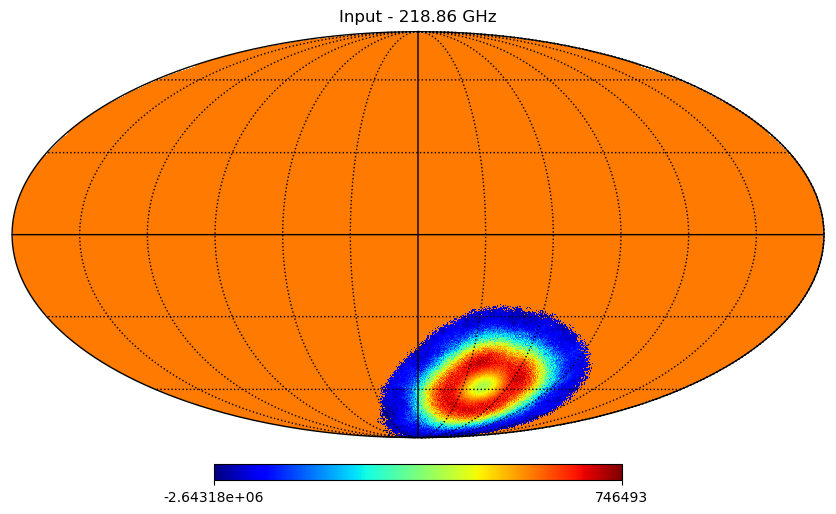

In [44]:
for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.mollview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet',title='Input - {:.2f} GHz'.format(true_frequencies[inu]))
    hp.graticule()

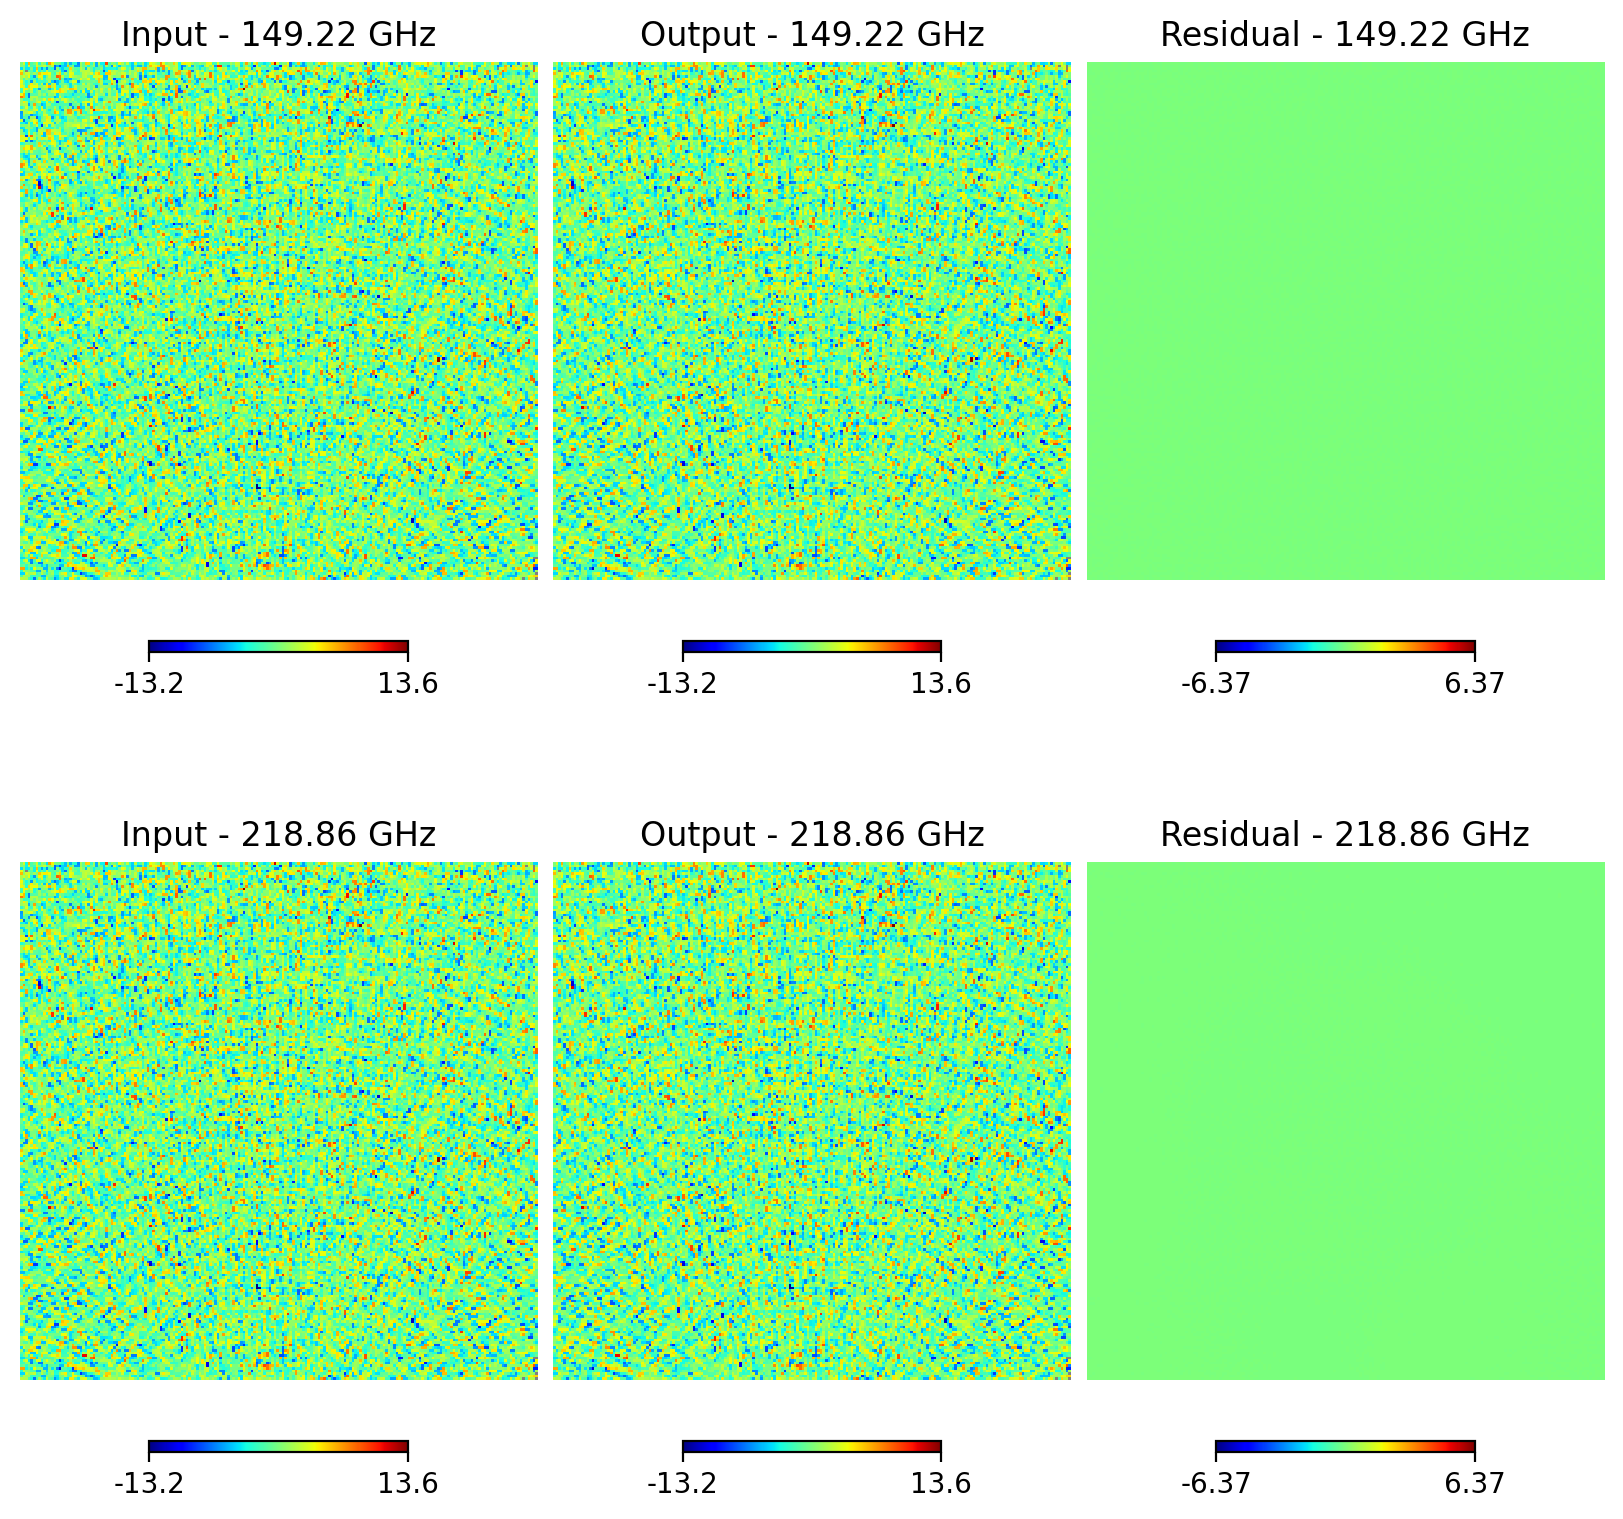

In [45]:
plt.figure(figsize=(8, 8), dpi=200)

k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 2

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, istk], min=-n_sig*sigma, max=n_sig*sigma, cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3

In [28]:
stop

NameError: name 'stop' is not defined